In [4]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import gzip
import os


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mnist-dataset


In [6]:
import os

# Replace with the actual variable if needed
print("Files in dataset directory:")
print(os.listdir(path))


Files in dataset directory:
['t10k-labels-idx1-ubyte', 'train-images.idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']


In [7]:
import numpy as np

def load_images(filename):
    with open(filename, 'rb') as f:
        f.read(16)  # skip header
        data = np.frombuffer(f.read(), dtype=np.uint8)
        images = data.reshape(-1, 28 * 28)
    return images / 255.0  # Normalize to [0, 1]

def load_labels(filename):
    with open(filename, 'rb') as f:
        f.read(8)  # skip header
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


In [8]:
import os

dataset_path = "/kaggle/input/mnist-dataset"
print("Files in dataset path:")
print(os.listdir(dataset_path))


Files in dataset path:
['t10k-labels-idx1-ubyte', 'train-images.idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']


In [9]:
import numpy as np
import os

dataset_path = "/kaggle/input/mnist-dataset"

def load_images(filepath):
    with open(filepath, 'rb') as f:
        f.read(16)  # Skip header
        data = np.frombuffer(f.read(), dtype=np.uint8)
        images = data.reshape(-1, 28 * 28)
    return images / 255.0

def load_labels(filepath):
    with open(filepath, 'rb') as f:
        f.read(8)  # Skip header
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images = load_images(os.path.join(dataset_path, "train-images-idx3-ubyte", "train-images-idx3-ubyte"))
train_labels = load_labels(os.path.join(dataset_path, "train-labels-idx1-ubyte", "train-labels-idx1-ubyte"))
test_images = load_images(os.path.join(dataset_path, "t10k-images-idx3-ubyte", "t10k-images-idx3-ubyte"))
test_labels = load_labels(os.path.join(dataset_path, "t10k-labels-idx1-ubyte", "t10k-labels-idx1-ubyte"))

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)


Train images shape: (60000, 784)
Train labels shape: (60000,)


# With Logistic Regression

In [10]:
# Convert labels: 1 if NOT zero, 0 if zero
y_train_bin = (train_labels != 0).astype(np.uint8)
y_test_bin = (test_labels != 0).astype(np.uint8)


In [11]:
# Initialize weights and bias
np.random.seed(42)
weights = np.random.randn(784) * 0.01  # one weight per pixel
bias = 0.0


In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y_true, y_pred):
    epsilon = 1e-8  # to avoid log(0)
    return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))


In [13]:
lr = 0.1  # learning rate
epochs = 100

for epoch in range(epochs):
    # Forward pass
    linear_output = np.dot(train_images, weights) + bias
    predictions = sigmoid(linear_output)

    # Compute loss
    loss = compute_loss(y_train_bin, predictions)

    # Backward pass (gradients)
    error = predictions - y_train_bin
    dw = np.dot(train_images.T, error) / len(train_images)
    db = np.mean(error)

    # Update parameters
    weights -= lr * dw
    bias -= lr * db

    if epoch % 10 == 0:
        print(f"Epoch {epoch} — Loss: {loss:.4f}")


Epoch 0 — Loss: 0.6873
Epoch 10 — Loss: 0.2154
Epoch 20 — Loss: 0.1588
Epoch 30 — Loss: 0.1324
Epoch 40 — Loss: 0.1170
Epoch 50 — Loss: 0.1068
Epoch 60 — Loss: 0.0993
Epoch 70 — Loss: 0.0935
Epoch 80 — Loss: 0.0889
Epoch 90 — Loss: 0.0851


In [14]:
test_preds = sigmoid(np.dot(test_images, weights) + bias)
test_preds_binary = (test_preds >= 0.5).astype(np.uint8)

accuracy = np.mean(test_preds_binary == y_test_bin)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")



Test Accuracy: 98.19%


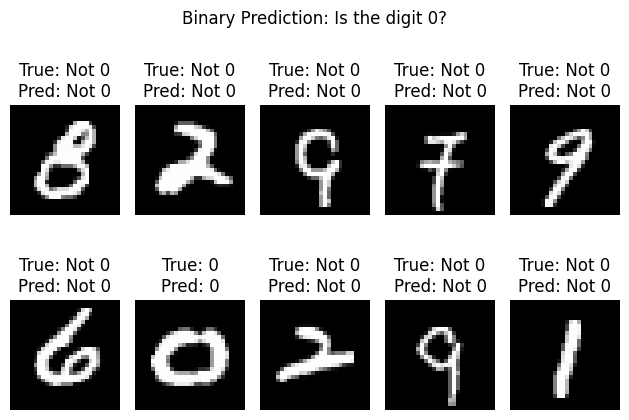

In [15]:
import matplotlib.pyplot as plt

# Pick a few test samples to visualize
num_samples = 10
indices = np.random.choice(len(test_images), num_samples, replace=False)

for i, idx in enumerate(indices):
    image = test_images[idx].reshape(28, 28)
    actual_label = 0 if y_test_bin[idx] == 0 else "Not 0"
    prediction = "0" if test_preds_binary[idx] == 0 else "Not 0"

    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {actual_label}\nPred: {prediction}")
    plt.axis('off')

plt.suptitle("Binary Prediction: Is the digit 0?")
plt.tight_layout()
plt.show()


# MultiClass Classification of Handwritten Digits

In [16]:
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

y_train_oh = one_hot_encode(train_labels, 10)
y_test_oh = one_hot_encode(test_labels, 10)


In [17]:
# 784 input features, 10 output classes
weights = np.random.randn(784, 10) * 0.01
bias = np.zeros(10)


In [18]:
def softmax(z):
    exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability trick
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-8
    return -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))


In [19]:
lr = 0.1
epochs = 100

for epoch in range(epochs):
    # Forward pass
    logits = np.dot(train_images, weights) + bias
    probs = softmax(logits)

    # Loss
    loss = cross_entropy_loss(y_train_oh, probs)

    # Gradients
    error = probs - y_train_oh
    dw = np.dot(train_images.T, error) / len(train_images)
    db = np.mean(error, axis=0)

    # Update weights
    weights -= lr * dw
    bias -= lr * db

    if epoch % 10 == 0:
        print(f"Epoch {epoch} — Loss: {loss:.4f}")


Epoch 0 — Loss: 2.3081
Epoch 10 — Loss: 1.5529
Epoch 20 — Loss: 1.1918
Epoch 30 — Loss: 0.9976
Epoch 40 — Loss: 0.8787
Epoch 50 — Loss: 0.7985
Epoch 60 — Loss: 0.7404
Epoch 70 — Loss: 0.6963
Epoch 80 — Loss: 0.6614
Epoch 90 — Loss: 0.6331


In [20]:
test_logits = np.dot(test_images, weights) + bias
test_probs = softmax(test_logits)
test_preds = np.argmax(test_probs, axis=1)

accuracy = np.mean(test_preds == test_labels)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")



Test Accuracy: 87.07%


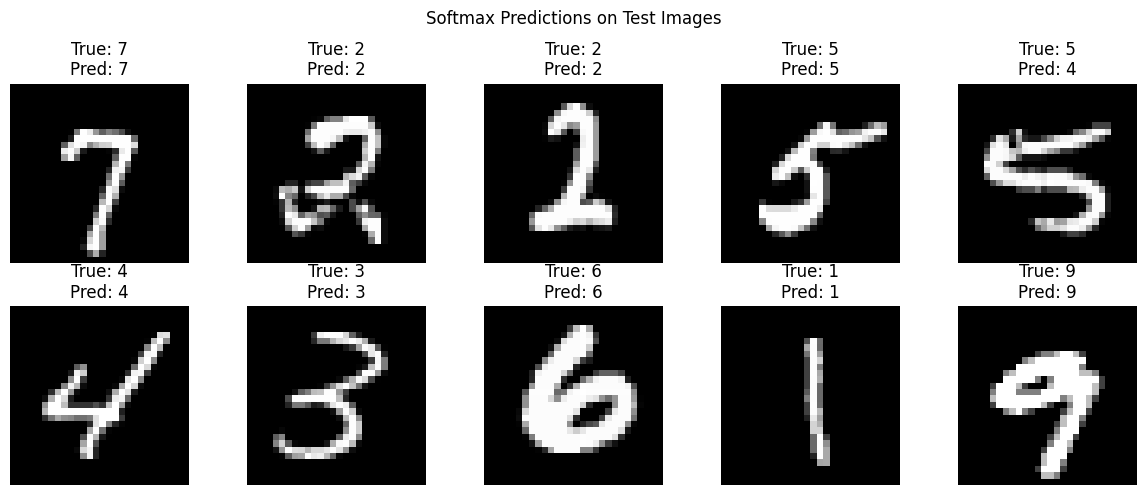

In [21]:
import matplotlib.pyplot as plt

# Select 10 random test images
num_samples = 10
indices = np.random.choice(len(test_images), num_samples, replace=False)

plt.figure(figsize=(12, 5))

for i, idx in enumerate(indices):
    image = test_images[idx].reshape(28, 28)
    true_label = test_labels[idx]
    predicted_label = test_preds[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.suptitle("Softmax Predictions on Test Images")
plt.tight_layout()
plt.show()


In [22]:
np.random.seed(42)

# Initialize weights and biases
input_size = 784  # 28x28 images
hidden_size = 64  # Hidden layer neurons
output_size = 10  # 10 digits (0-9)

# Weights for input to hidden layer
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros(hidden_size)

# Weights for hidden to output layer
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros(output_size)


In [23]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-8
    return -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))


In [24]:
epochs = 100
lr = 0.1  # Learning rate

for epoch in range(epochs):
    # Forward pass: Input -> Hidden
    z1 = np.dot(train_images, W1) + b1
    a1 = relu(z1)

    # Forward pass: Hidden -> Output
    z2 = np.dot(a1, W2) + b2
    output = softmax(z2)

    # Compute loss
    loss = cross_entropy_loss(y_train_oh, output)

    # Backward pass: Output -> Hidden
    dz2 = output - y_train_oh
    dw2 = np.dot(a1.T, dz2) / len(train_images)
    db2 = np.mean(dz2, axis=0)

    # Backward pass: Hidden -> Input
    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * (a1 > 0)  # ReLU derivative
    dw1 = np.dot(train_images.T, dz1) / len(train_images)
    db1 = np.mean(dz1, axis=0)

    # Update weights and biases
    W1 -= lr * dw1
    b1 -= lr * db1
    W2 -= lr * dw2
    b2 -= lr * db2

    if epoch % 10 == 0:
        print(f"Epoch {epoch} — Loss: {loss:.4f}")


Epoch 0 — Loss: 2.3027
Epoch 10 — Loss: 2.2963
Epoch 20 — Loss: 2.2847
Epoch 30 — Loss: 2.2601
Epoch 40 — Loss: 2.2071
Epoch 50 — Loss: 2.1049
Epoch 60 — Loss: 1.9389
Epoch 70 — Loss: 1.7137
Epoch 80 — Loss: 1.4687
Epoch 90 — Loss: 1.2522


In [25]:
# Forward pass on test set
test_z1 = np.dot(test_images, W1) + b1
test_a1 = relu(test_z1)
test_z2 = np.dot(test_a1, W2) + b2
test_output = softmax(test_z2)

# Predicted labels
test_preds = np.argmax(test_output, axis=1)

# Accuracy
accuracy = np.mean(test_preds == test_labels)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")



Test Accuracy: 76.44%


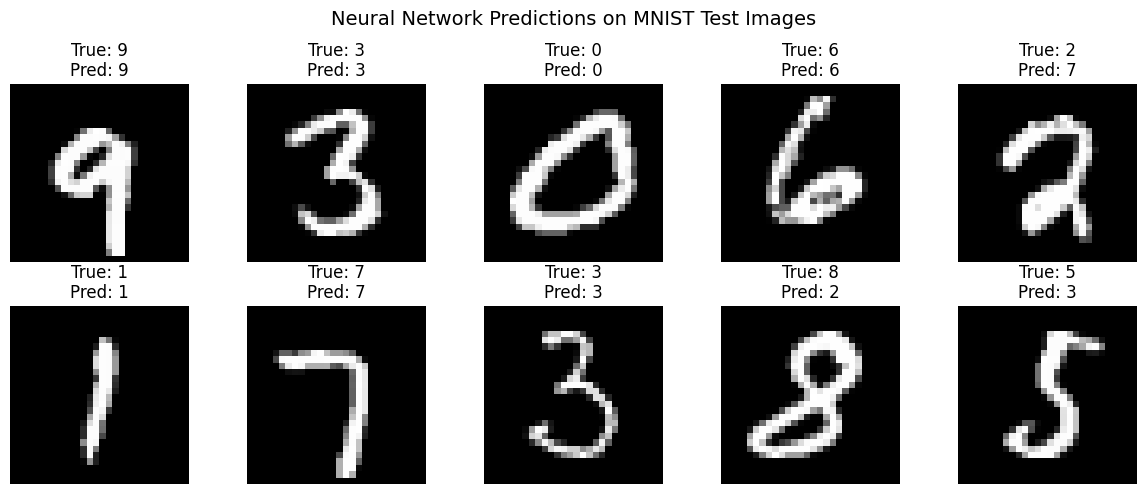

In [26]:
import matplotlib.pyplot as plt

# Pick 10 random test images
num_samples = 10
indices = np.random.choice(len(test_images), num_samples, replace=False)

plt.figure(figsize=(12, 5))

for i, idx in enumerate(indices):
    image = test_images[idx].reshape(28, 28)
    true_label = test_labels[idx]
    predicted_label = test_preds[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.suptitle("Neural Network Predictions on MNIST Test Images", fontsize=14)
plt.tight_layout()
plt.show()


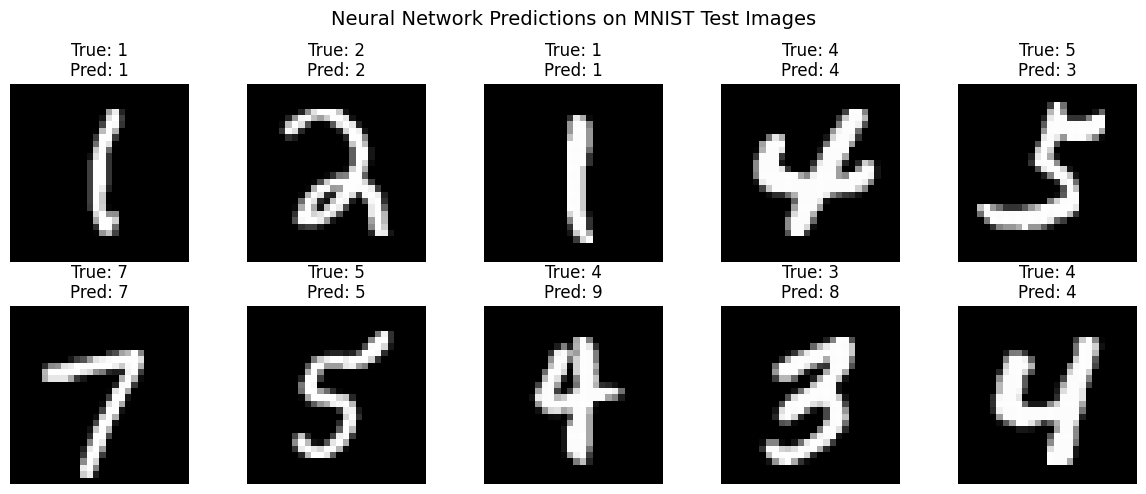

In [30]:
import matplotlib.pyplot as plt

# Pick 10 random test images
num_samples = 10
indices = np.random.choice(len(test_images), num_samples, replace=False)

plt.figure(figsize=(12, 5))

for i, idx in enumerate(indices):
    image = test_images[idx].reshape(28, 28)
    true_label = test_labels[idx]
    predicted_label = test_preds[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.suptitle("Neural Network Predictions on MNIST Test Images", fontsize=14)
plt.tight_layout()
plt.show()


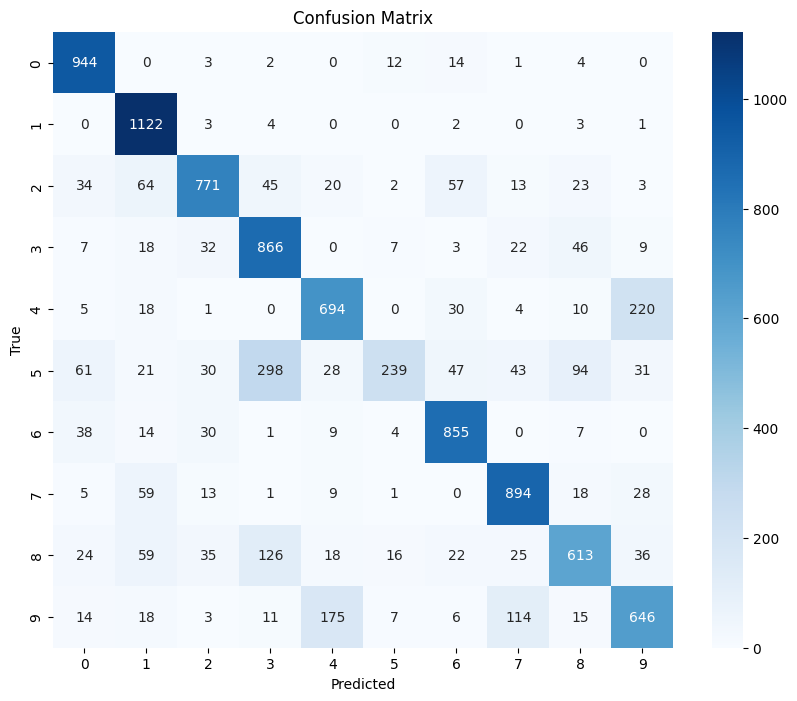

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [31]:
# Save model weights and biases
np.savez("mnist_nn_model.npz", W1=W1, b1=b1, W2=W2, b2=b2)


In [32]:
# Load saved model
data = np.load("mnist_nn_model.npz")
W1 = data['W1']
b1 = data['b1']
W2 = data['W2']
b2 = data['b2']
